# Imports

In [1]:
import pandas as pd
from os import chdir, scandir, makedirs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook as tqdm

import os

from itertools import cycle
from multiprocessing import Pool, cpu_count

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
from hit_finding.constants import *
from hit_finding.metrics import *

# Compare Visual an Tabular Results

In [6]:
zscores = extract_scores_from_all(extract_score, threshold=4)
tbl_zscores = pd.concat(zscores.values())
tbl_zscores.shape

...................................

(11197, 18)

In [7]:
vis_res_path = r'../visual_models_results/final_results/4to1'
os.makedirs(f'{vis_res_path}/zscores', exist_ok=True)

In [8]:
def extract_zscores_visual(vis_res_path, p):
    zscore_path = f'{vis_res_path}/zscores/{p}'
    if os.path.exists(zscore_path):
        return pd.read_csv(zscore_path, index_col=list(range(4)))
    
    
    df = pd.read_csv(f'{vis_res_path}/{p}', index_col=list(range(6)))

    df = df.groupby(['Plate','Well_Role','Well','Broad_Sample']).mean()

    pcc_all = df.filter(regex='PCC_', axis=1).mean(axis=1)
    pcc_all.name = 'PCC_ALL'
    mse_all = df.filter(regex='MSE_', axis=1).mean(axis=1)
    mse_all.name = 'MSE_ALL'

    df = pd.concat([df,pcc_all,mse_all], axis=1)

    df_mock = df.query('Well_Role == "mock"')
    scaler = StandardScaler()
    scaler.fit(df_mock)
    del df_mock

    df_zscores = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    del df
    df_zscores.to_csv(zscore_path)
    
    return df_zscores

In [9]:
vis_zscores = [extract_zscores_visual(vis_res_path, p) for p in tqdm(os.listdir(vis_res_path)) if p[-4:] == '.csv']
vis_zscores = pd.concat(vis_zscores)
vis_zscores = vis_zscores.query('Well_Role != "mock"')
vis_zscores.index = vis_zscores.index.droplevel(1).swaplevel(1,2)
vis_zscores.shape

(11197, 12)

In [10]:
all_scores = tbl_zscores.join(vis_zscores, on=['Plate', 'Metadata_broad_sample', 'Image_Metadata_Well'])
all_scores.shape

(11197, 30)

In [11]:
all_scores.columns

Index(['AGP_map', 'DNA_map', 'ER_map', 'Mito_map', 'RNA_map', 'ALL_map',
       'AGP_raw', 'DNA_raw', 'ER_raw', 'Mito_raw', 'RNA_raw', 'ALL_raw',
       'AGP_raw1to1', 'DNA_raw1to1', 'ER_raw1to1', 'Mito_raw1to1',
       'RNA_raw1to1', 'ALL_raw1to1', 'PCC_AGP', 'MSE_AGP', 'PCC_DNA',
       'MSE_DNA', 'PCC_ER', 'MSE_ER', 'PCC_Mito', 'MSE_Mito', 'PCC_RNA',
       'MSE_RNA', 'PCC_ALL', 'MSE_ALL'],
      dtype='object')

In [12]:
CHANNELS

['AGP', 'DNA', 'ER', 'Mito', 'RNA']

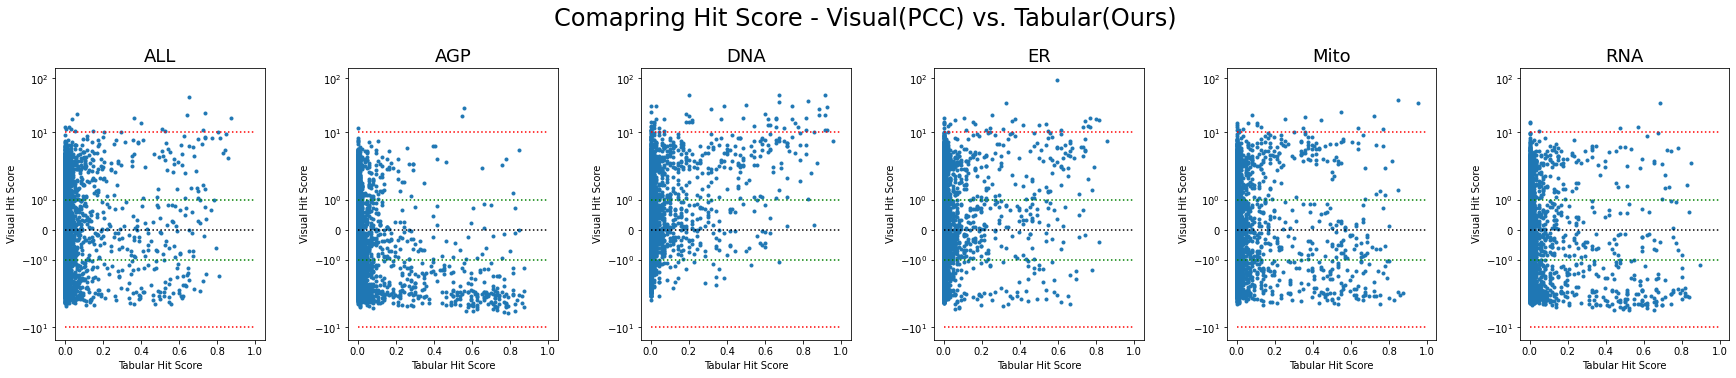

In [69]:
ncol = 6
nrow = 1

d={'xlabel':"Tabular Hit Score", 'ylabel':"Visual Hit Score"}
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), sharey=True, sharex=True, subplot_kw=d)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle(f'Comapring Hit Score - Visual(PCC) vs. Tabular(Ours)', fontsize = 24, y=1.05)

for i, chan in enumerate(['ALL'] + CHANNELS):
    ax[i].set_yscale('symlog', base=10)
#     ax[i].set_xscale('symlog', base=10)
#     ax[i].set(xlim=(0, 40), ylim=(0, 40))
    
    ax[i].plot(all_scores[f'{chan}_map'], all_scores[f'PCC_{chan}']*-1, '.')
    ax[i].plot([0,1], [0,0], 'k:')
    ax[i].plot([0,1], [1,1], 'g:')
    ax[i].plot([0,1], [-1,-1], 'g:')
    ax[i].plot([0,1], [10,10], 'r:')
    ax[i].plot([0,1], [-10,-10], 'r:')

    ax[i].set_title(chan, fontsize = 18)
    ax[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)

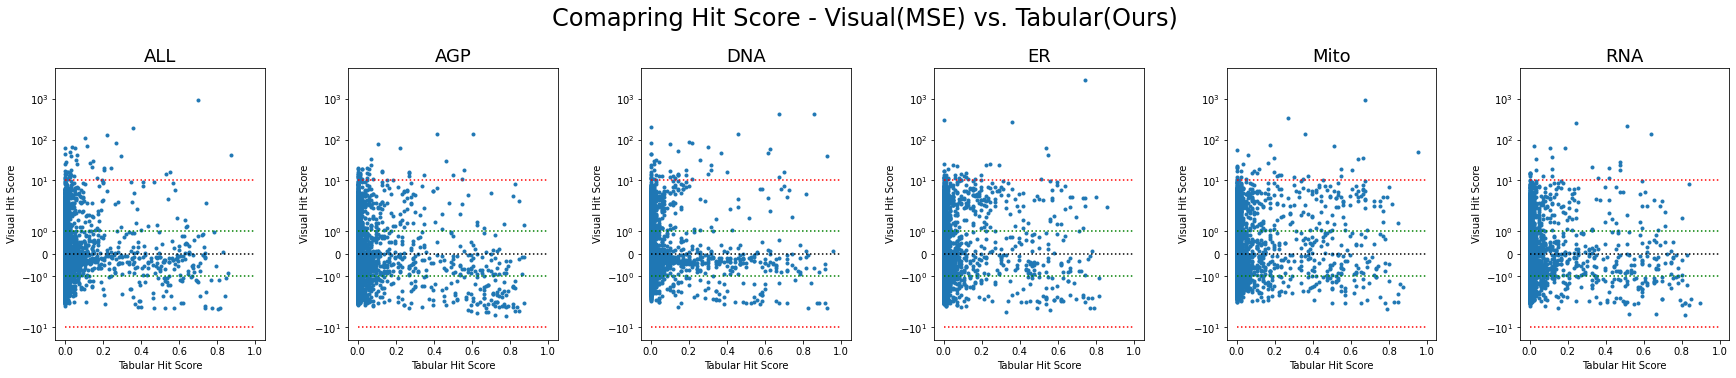

In [70]:
ncol = 6
nrow = 1

d={'xlabel':"Tabular Hit Score", 'ylabel':"Visual Hit Score"}
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), sharey=True, sharex=True, subplot_kw=d)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle(f'Comapring Hit Score - Visual(MSE) vs. Tabular(Ours)', fontsize = 24, y=1.05)

for i, chan in enumerate(['ALL'] + CHANNELS):
    ax[i].set_yscale('symlog', base=10)
#     ax[i].set_xscale('symlog', base=10)
#     ax[i].set(xlim=(0, 40), ylim=(0, 40))
    
    ax[i].plot(all_scores[f'{chan}_map'], all_scores[f'MSE_{chan}'], '.')
    ax[i].plot([0,1], [0,0], 'k:')
    ax[i].plot([0,1], [1,1], 'g:')
    ax[i].plot([0,1], [-1,-1], 'g:')
    ax[i].plot([0,1], [10,10], 'r:')
    ax[i].plot([0,1], [-10,-10], 'r:')

    ax[i].set_title(chan, fontsize = 18)
    ax[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)

In [ ]:
all_scores.query('ALL_map >= 0.8719')

,,,AGP_map,DNA_map,ER_map,Mito_map,RNA_map,ALL_map,AGP_raw,DNA_raw,ER_raw,Mito_raw,...,PCC_DNA,MSE_DNA,PCC_ER,MSE_ER,PCC_Mito,MSE_Mito,PCC_RNA,MSE_RNA,PCC_ALL,MSE_ALL
Plate,Metadata_broad_sample,Image_Metadata_Well,,,,,,,,,,,,,,,,,,,,,
25708,BRD-K05556515-001-07-4,g15,0.848837,0.928571,0.802326,0.953488,0.837209,0.871981,0.546512,0.657143,0.616279,0.674419,...,-10.968583,38.985595,-17.701569,3.912999,-34.32341,50.285645,-0.582949,8.177447,-18.037074,41.5


In [53]:
from scipy.stats import pearsonr

In [60]:
for i, chan in enumerate(['ALL'] + CHANNELS):
    print(pearsonr(all_scores.query(f'{chan}_map > 0.8')[f'{chan}_map'], all_scores.query(f'{chan}_map > 0.8')[f'PCC_{chan}'])[0])

-0.4591042644995134
0.1300341749419902
-0.28607040234325115
0.36161139553772603
-0.57942839982562
-0.34126329765436864


In [76]:
all_scores.filter(regex='ALL', axis=1)

ALL_map   ALL_raw  \
Plate Metadata_broad_sample  Image_Metadata_Well                       
24294 BRD-A00100033-001-04-8 a01                  0.004831  0.002415   
      BRD-A00267231-001-01-1 a02                  0.014493  0.000000   
      BRD-A00327403-103-01-9 a03                  0.000000  0.000000   
      BRD-A00520476-001-03-3 a04                  0.000000  0.000000   
      BRD-A00827783-001-04-8 a05                  0.000000  0.000000   
...                                                    ...       ...   
26786 BRD-K98956791-001-01-2 i23                  0.000000  0.000000   
      BRD-K99149118-001-01-9 f08                  0.000000  0.000000   
      BRD-K99547414-001-01-5 i17                  0.000000  0.000000   
      BRD-K99615821-001-01-7 c23                  0.041063  0.036232   
      BRD-K99647384-001-01-9 o08                  0.000000  0.000000   

                                                  ALL_raw1to1   PCC_ALL  \
Plate Metadata_broad_sample  Image_Metadata_Well                          
24294 BRD-A00100033-001-04-8 a01                     0.002415 -1.170394   
      BRD-A00267231-001-01-1 a02                     0.000000 -0.640408   
      BRD-A00327403-103-01-9 a03                     0.000000 -1.663104   
      BRD-A00520476-001-03-3 a04                     0.000000  1.864810   
      BRD-A00827783-001-04-8 a05                     0.000000  1.893704   
...                                                       ...       ...   
26786 BRD-K98956791-001-01-2 i23                     0.000000 -1.261679   
      BRD-K99149118-001-01-9 f08                     0.000000  1.230499   
      BRD-K99547414-001-01-5 i17                     0.000000 -1.503873   
      BRD-K99615821-001-01-7 c23                     0.031401  2.984652   
      BRD-K99647384-001-01-9 o08                     0.000000  1.897263   

                                                   MSE_ALL  
Plate Metadata_broad_sample  Image_Metadata_Well            
24294 BRD-A00100033-001-04-8 a01                  0.115724  
      BRD-A00267231-001-01-1 a02                 -0.345255  
      BRD-A00327403-103-01-9 a03                 -0.148017  
      BRD-A00520476-001-03-3 a04                 -0.151868  
      BRD-A00827783-001-04-8 a05                 -0.250879  
...                                                    ...  
26786 BRD-K98956791-001-01-2 i23                 -0.570040  
      BRD-K99149118-001-01-9 f08                 -0.497906  
      BRD-K99547414-001-01-5 i17                  0.068748  
      BRD-K99615821-001-01-7 c23                 -1.076033  
      BRD-K99647384-001-01-9 o08                 -0.642137  

[11197 rows x 5 columns]

In [26]:
for c in CHANNELS + ['ALL']:
    all_scores[f'PCC_{c}'] = all_scores[f'PCC_{c}'] * -1

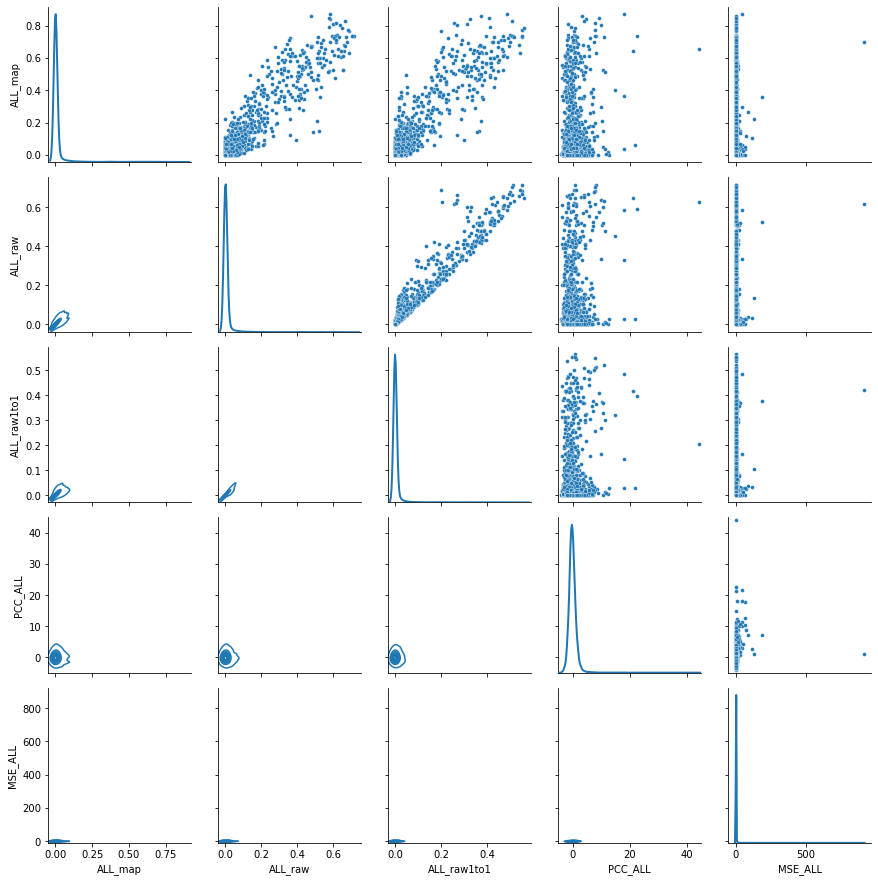

In [27]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='ALL', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

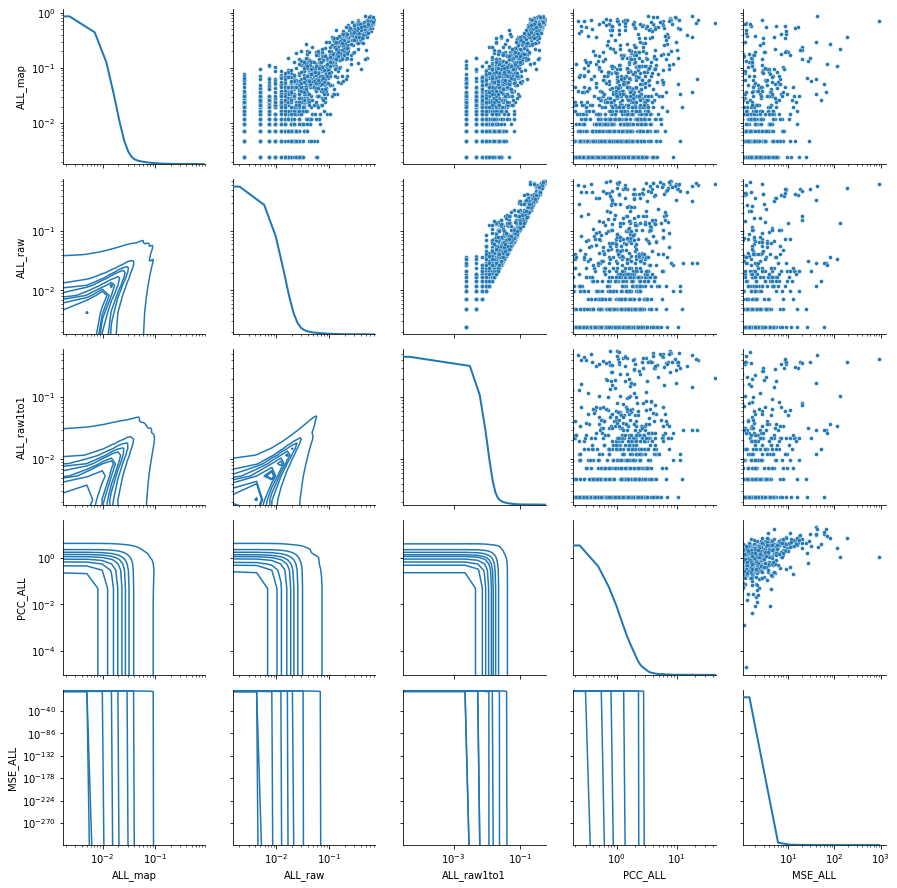

In [28]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='ALL', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
for axs in g.axes:
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')


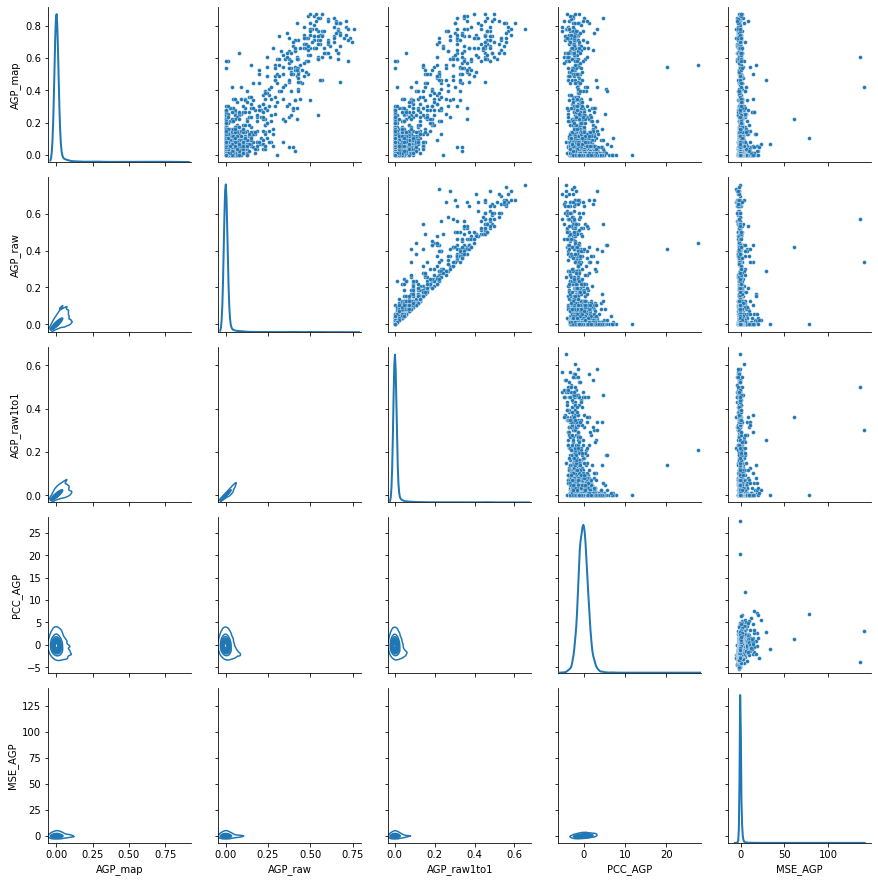

In [29]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='AGP', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

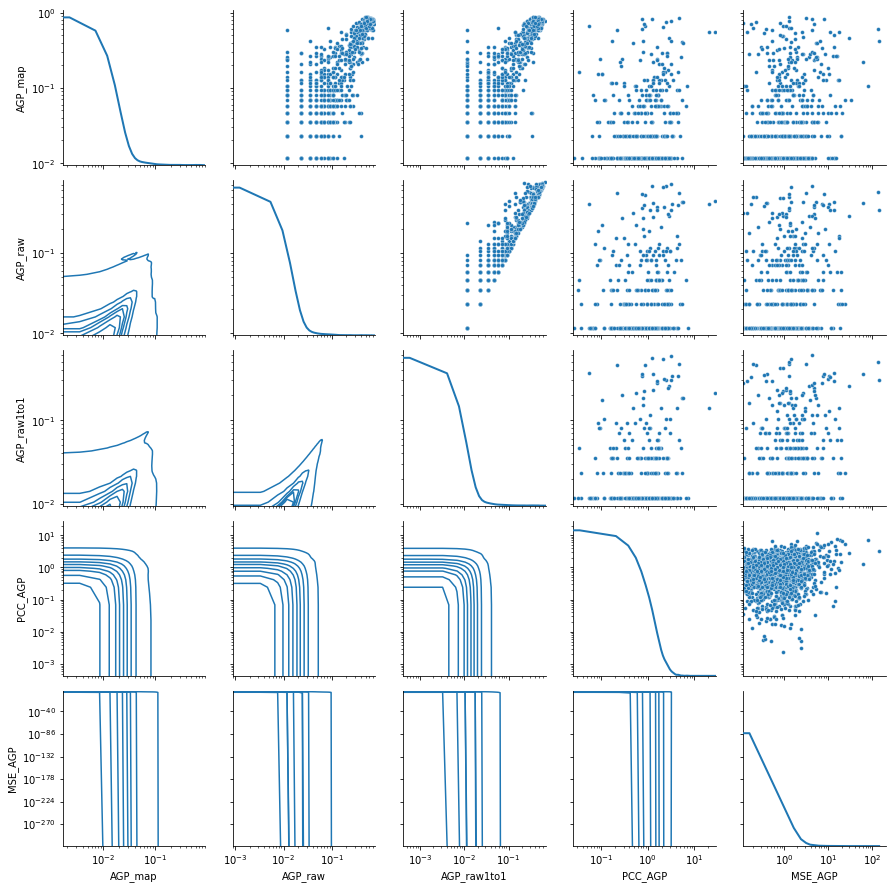

In [34]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='AGP', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

for axs in g.axes:
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

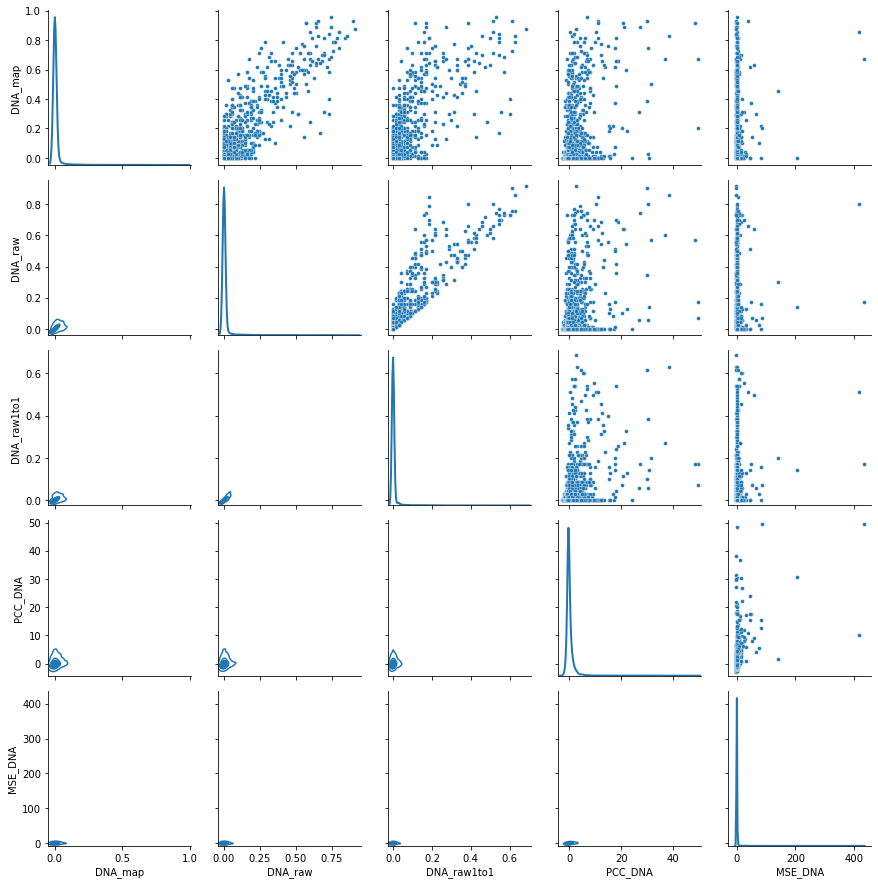

In [30]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='DNA', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

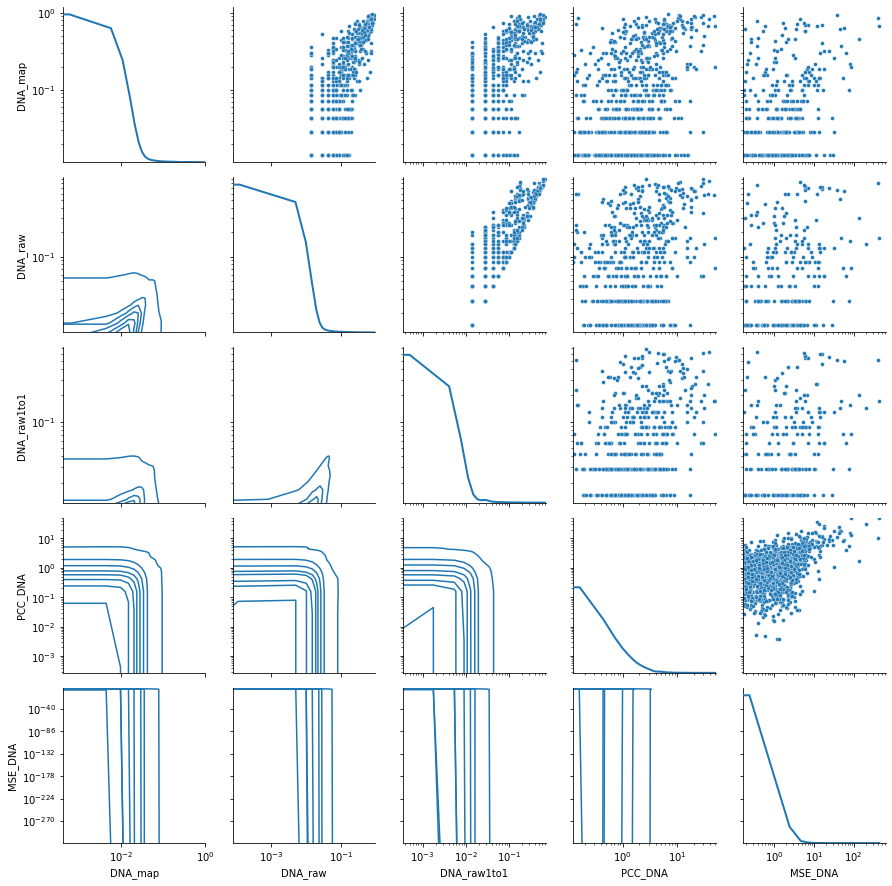

In [35]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='DNA', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
for axs in g.axes:
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

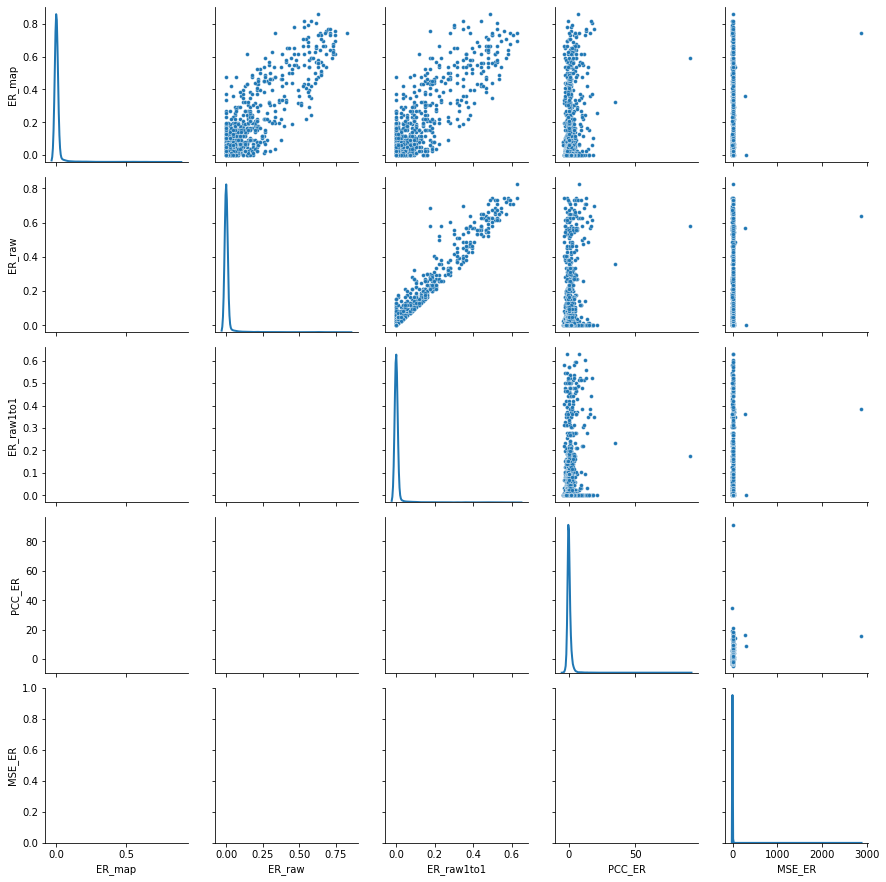

In [36]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='ER', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

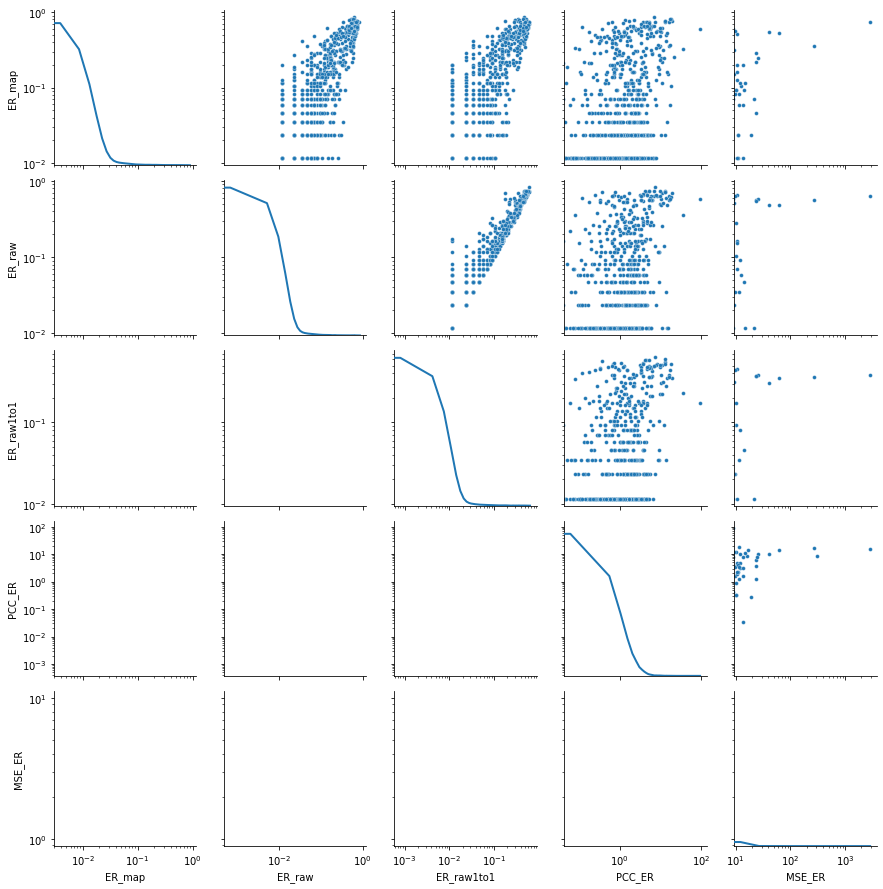

In [37]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='ER', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
for axs in g.axes:
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

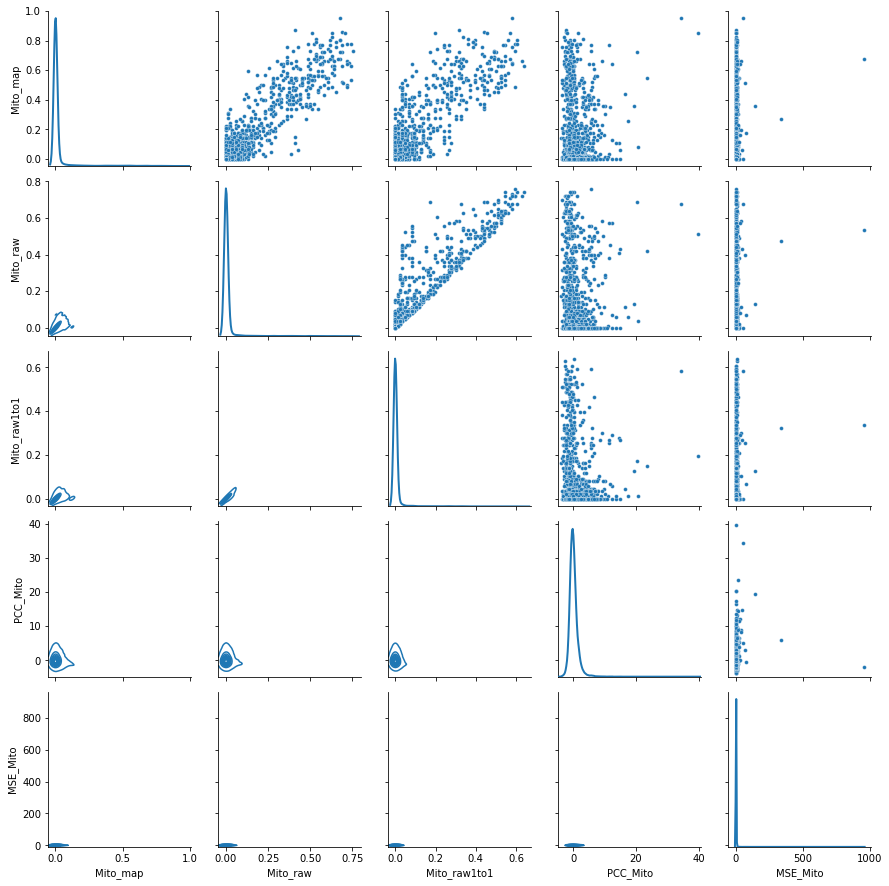

In [32]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='Mito', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

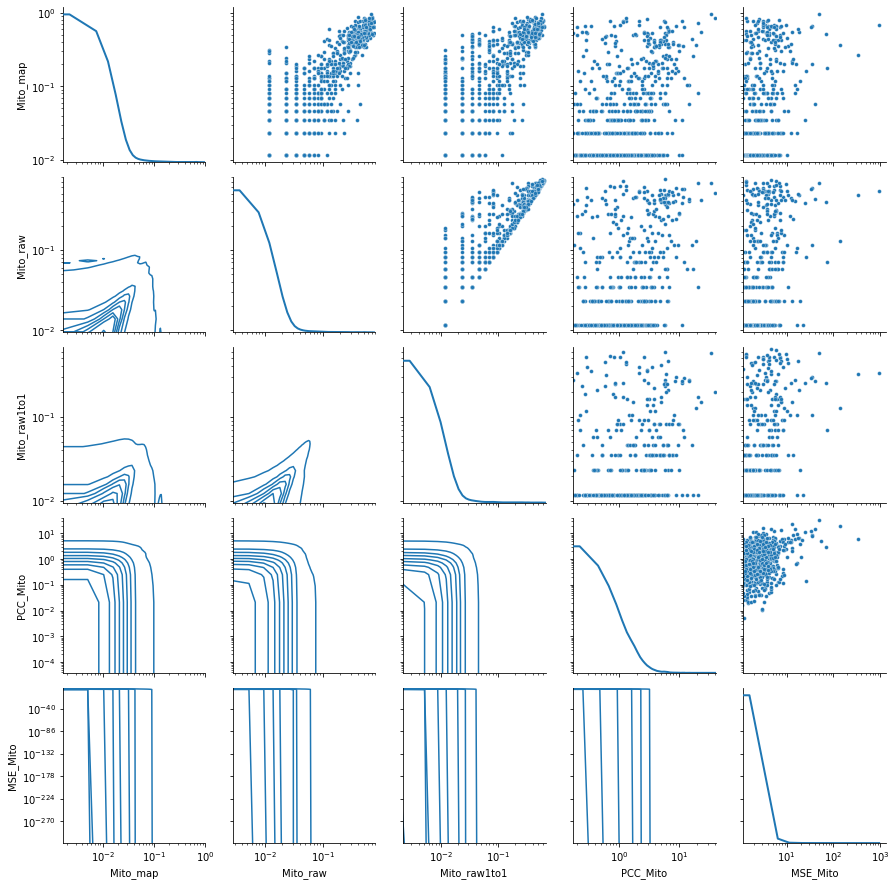

In [38]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='Mito', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
for axs in g.axes:
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

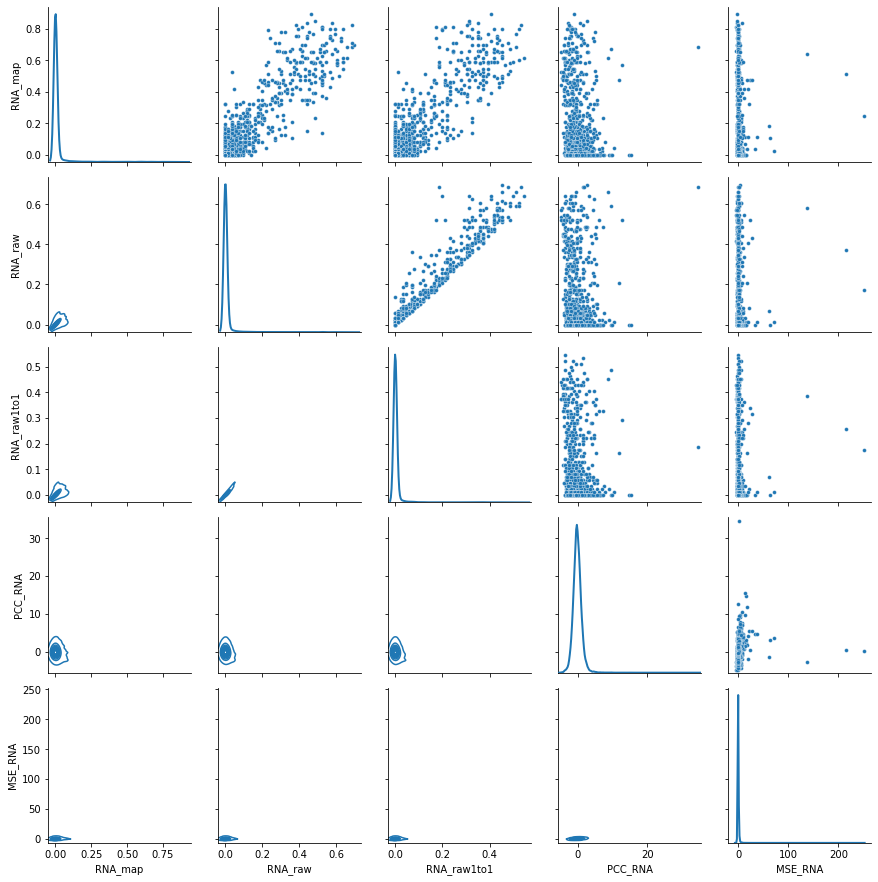

In [33]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='RNA', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

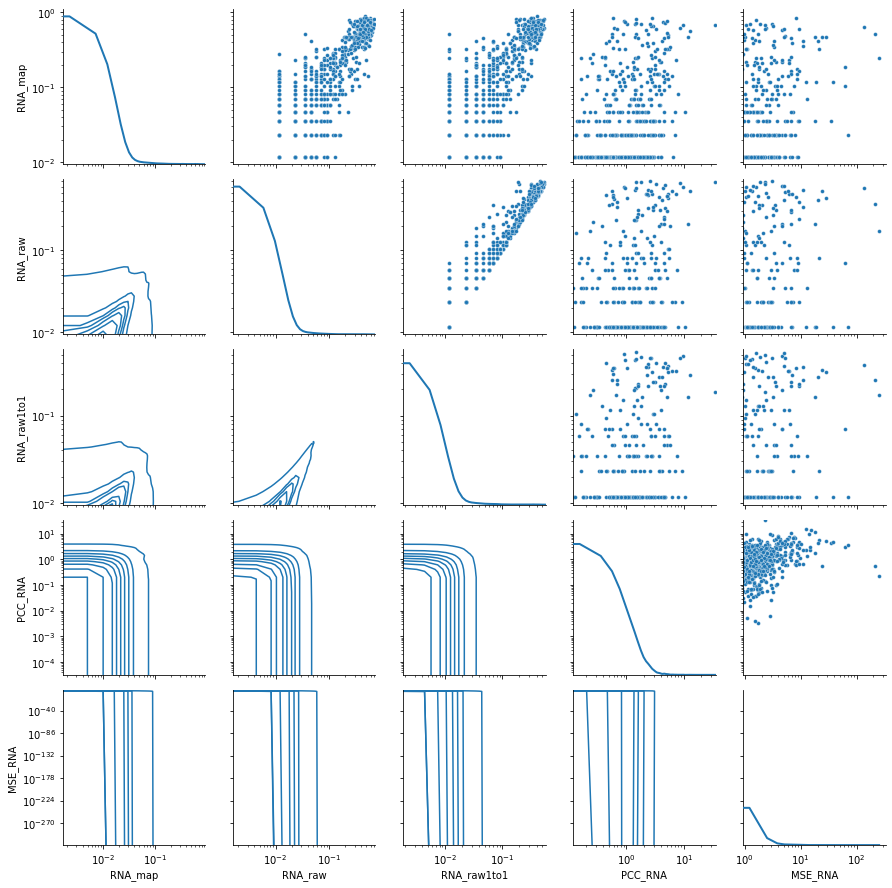

In [39]:
import seaborn as sns

g = sns.PairGrid(all_scores.filter(regex='RNA', axis=1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
for axs in g.axes:
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')